In [16]:
# !pip install jsonlines

In [17]:
from pydantic import BaseModel, Field
from enum import Enum
from typing import Optional, List
from openai import OpenAI
from typing import Dict
from tqdm import tqdm
import json
import jsonlines
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, time, pathlib
from datetime import datetime
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [18]:
class ModelType(str, Enum):
    PRETRAINED = "pretrained"
    FINE_TUNED = "fine_tuned"

# Change this according the model type
MODEL_TYPE = ModelType.FINE_TUNED
# -------------------------------------

PORT = "7001"
BASE_PATH = "/home/odedh/SML-For-Debug"
TEST_DATASET_PATH = f"{BASE_PATH}/data/dataset2.0/test_2.0.json"
OUTPUT_BENCHMARK = f"outputs/0.2/benchmark_results_Llama-1B_{MODEL_TYPE}.json"
BENCHMARK_PATH = f"{BASE_PATH}/benchmark/{OUTPUT_BENCHMARK}"
# dataset_path = "/home/odedh/SML-For-Debug/data/dataset/pyresbugs_test.jsonl"

In [19]:
client = OpenAI(
    base_url=f"http://localhost:{PORT}/v1",
    api_key="-",
)
model = client.models.list().data[0].id
model

'/models/trained/Llama-3.2-1B-Instruct_SFT_0.9/checkpoint-1500'

In [20]:
def benchmark_openai_structured_model(
    test_data: List[Dict],
    client,
    output_path: str = None,
    temperature: float = 0.0,
    max_tokens: int = 4096,
    save_every: int = 25,
    start_index: int = 0,
):
    benchmark_results = []

    # Check if output file exists and resume from there
    if output_path and os.path.exists(output_path):
        with open(output_path, "r") as f:
            benchmark_results = json.load(f)
        start_index = len(benchmark_results)
        print(f"Resuming from index {start_index}, loaded {len(benchmark_results)} existing results.")

    for i in tqdm(range(start_index, len(test_data)), desc=f"Benchmarking {model}"):
        entry = test_data[i]
        messages = [m for m in entry["prompt"] if m["role"] != "assistant"]
        payload = messages[1]['content']
        
        # Should be OK: a string
        assert isinstance(payload, str)

        # After decoding, you should have real newlines, not the two-character sequence '\n'
        decoded = json.loads(payload)
        assert "\n" in decoded["context_diff"]
        assert "\\n" not in decoded["context_diff"]
        
        try:
            completion = client.chat.completions.create(
                model=model,
                temperature=temperature,
                max_tokens=max_tokens,
                messages=[
                    messages[0], # System message
                    {"role": "user", "content": [{"type": "text", "text": payload}]}, # User message
                ],
            )

            output_content = completion.choices[0].message.content

            benchmark_results.append({
                "index": i,
                "input": messages,
                "output": output_content
            })

        except Exception as e:
            benchmark_results.append({
                "index": i,
                "input": messages,
                "error": str(e)
            })

        # Save progress every `save_every` entries
        if output_path and (i + 1) % save_every == 0:
            with open(output_path, "w") as f:
                json.dump(benchmark_results, f, indent=2)
            

    # Final save
    if output_path:
        with open(output_path, "w") as f:
            json.dump(benchmark_results, f, indent=2)
        print("Final results saved.")

    return benchmark_results

In [21]:
with open(TEST_DATASET_PATH) as reader:
    test_set = json.load(reader)

results = benchmark_openai_structured_model(
    test_data=test_set,
    client=client,
    output_path=OUTPUT_BENCHMARK,
    save_every=1,
)


Benchmarking /models/trained/Llama-3.2-1B-Instruct_SFT_0.9/checkpoint-1500:   0%|          | 0/317 [00:00<?, ?it/s]

Benchmarking /models/trained/Llama-3.2-1B-Instruct_SFT_0.9/checkpoint-1500: 100%|██████████| 317/317 [13:26<00:00,  2.54s/it]

Final results saved.


---  
### Creating the benchmark DF - LLM-as-a-judge - https://huggingface.co/learn/cookbook/llm_judge

---

In [22]:
# Reading all model's outputs
with open(BENCHMARK_PATH, "r") as f:
    benchmark_results = json.load(f)
# Reading all ground truth outputs
with open(TEST_DATASET_PATH, "r") as f:
    test_set = json.load(f)

# If the content is a string, parse it as JSON
if type(benchmark_results[0]['input'][1]['content']) == str:
    benchmark_results = [{**r, "input": [r["input"][0], {**r["input"][1], "content": json.loads(r["input"][1]["content"])}]} for r in benchmark_results]
    
# Create a dataframe with only the index, buggy_function_code, and output
benchmark_df = pd.DataFrame([
    {
        "index": result["index"],
        "faulty_function": result["input"][1]["content"]["buggy_function_code"],
        "fault_free_function": gt['completion'][0]['content'],
        "model_output": result.get("output", ""),
    } for result, gt in zip(benchmark_results, test_set)])

benchmark_df.head()


,index,faulty_function,fault_free_function,model_output
0,0,"def searchsorted(self, value, side=""left"", sor...","def searchsorted(self, value, side=""left"", sor...","def searchsorted(self, value, side=""left"", sor..."
1,1,"def collect(self, module=None, collected_facts...","def collect(self, module=None, collected_facts...","def collect(self, module=None, collected_facts..."
2,2,"def _labels_to_key(self, labels):\n try...","def _labels_to_key(self, labels):\n try...","def _labels_to_key(self, labels):\n try..."
3,3,"def _factorize_keys(lk, rk, sort=True):\n l...","def _factorize_keys(\n lk: ArrayLike, rk: A...","def _factorize_keys(\n lk: ArrayLike, rk: A..."
4,4,def __reduce__(self):\n return EcsOpera...,def __reduce__(self):\n return EcsTaskF...,def __reduce__(self):\n return EcsOpera...


In [23]:
JODGE_PROMPT = """
You are Python function fix judge an expert code reviewer.
Your task: given a JSON input containing three Python functions—

```json
{
  "faulty_function": "<string with the original  buggy function>",
  "fault_free_function": "<string with the correct reference function>",
  "model_output": "<string with the candidate fixed function>"
}
```

—decide whether `model_output` **correctly fixes the bug(s)** present in `faulty_function`, in a way that **matches the intended behavior** of `fault_free_function`.
Return **exactly one token**: `True` or `False`.
No explanations, no punctuation, no code fences, no whitespace beyond the single token.

## What to Evaluate (semantic, not textual)

Do **not** compare `model_output` to `fault_free_function` via string or AST equality. Judge by **behavioral equivalence** and correctness:

1. **Bug Identification:**
   Infer the defect(s) in `faulty_function` (logic errors, off-by-one, wrong condition, data mutation, exception handling, boundary cases, time/space issues that cause incorrect results, etc.).

2. **Intended Behavior:**
   Use `fault_free_function` as an oracle for the **intended I/O contract** and edge-case handling (what inputs should map to what outputs; which errors should be raised; whether side effects are allowed).

3. **Fix Verification:**
   Determine whether `model_output`:

   * Eliminates the defect(s) found in `faulty_function`.
   * Preserves the intended **public interface** (name, parameters, return type/shape) unless a trivial refactor (e.g., param names) does not change the contract.
   * Matches the **observable behavior** of `fault_free_function` on typical and edge inputs (including corner cases implied by the reference).
   * Avoids introducing new defects, side effects, global state reliance, nondeterminism, or extraneous I/O (prints, logging) that alter behavior.
   * Is **runnable Python** (syntactically valid) without adding unauthorized dependencies or external resources.

4. **Refactor Tolerance:**
   Allow different but equivalent implementations (renamed variables, reorganized control flow, alternative algorithms) if they implement the same contract and semantics.

## Disqualifiers (return `False`)

Return `False` if **any** of the following hold:

* The candidate is syntactically invalid or cannot run as a standalone function given the same context as the faulty/reference versions.
* The function signature/contract is materially changed (added/removed params, return type/shape changed, changed exception policy) without clear necessity for correctness.
* The fix leaves the original bug unresolved, only partially fixes it, or introduces new logical/edge-case failures.
* The function adds disallowed side effects (I/O, global state changes) or hidden dependencies.
* The behavior diverges from the reference on plausible inputs or boundary conditions implied by the reference.

## Tie-breaking & Uncertainty

If you cannot confidently establish behavioral correctness relative to the reference intent, output `False`.

## Process Requirements

* You may analyze, simulate execution, and reason about edge cases **internally**, but you must output only `True` or `False`.
* Do **not** execute external tools or the internet. Base your judgment solely on the three provided code strings.

**Final instruction:** Output exactly `True` or `False` and nothing else.
"""

In [24]:
CHECKPOINT_DIR = pathlib.Path("./gpt_eval_checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)
CHECKPOINT_PARQUET = CHECKPOINT_DIR / f"benchmark_df_gpt_eval_{MODEL_TYPE}.parquet"

# Save every N API calls
SAVE_EVERY = 10

# Model & prompt
MODEL_NAME = "gpt-4.1"
SYSTEM_PROMPT = JODGE_PROMPT  # uses your exact text

In [25]:
def call_judge_api(faulty_function: str, fault_free_function: str, model_output: str,
                   max_retries: int = 3, base_backoff: float = 2.0) -> str:
    """
    Calls model with the judging system prompt.
    Returns a raw string expected to be exactly 'True' or 'False'.
    Retries with exponential backoff on transient failures.
    """
    payload = {
        "faulty_function": faulty_function,
        "fault_free_function": fault_free_function,
        "model_output": model_output,
    }

    last_err = None
    for attempt in range(max_retries):
        try:
            # Responses API: pass system + input as plain text (JSON)
            resp = client.chat.completions.create(
                model=MODEL_NAME,
                temperature=0,
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": json.dumps(payload, ensure_ascii=False)}
                    ]
            )
            # Unified SDK provides a convenience accessor:
            out = resp.choices[0].message.content.strip()
            return out
        except Exception as e:
            last_err = e
            sleep_s = base_backoff ** attempt + (0.01 * attempt)
            time.sleep(sleep_s)

    # If we exhausted retries, raise
    raise RuntimeError(
        f"OpenAI call failed after {max_retries} retries: {last_err}")


def coerce_to_bool_token(s: str):
    """
    Accepts only strict 'True' / 'False' (case-sensitive).
    If model returns otherwise, try light normalization; else return None.
    """
    if s == "True":
        return True
    if s == "False":
        return False
    # light normalization for minor deviations
    s_clean = s.strip().split()[0].strip("`").strip().title()
    if s_clean in ("True", "False"):
        return s_clean == "True"
    return None


def save_checkpoint(df: pd.DataFrame):
    df.to_parquet(CHECKPOINT_PARQUET, index=False)
    # print(f"[{datetime.now().isoformat(timespec='seconds')}] Saved checkpoint → "
        #   f"{CHECKPOINT_PARQUET.name}")


def load_or_initialize_df(original_df: pd.DataFrame) -> pd.DataFrame:
    """
    Resume from checkpoint if present, else start from provided df.
    Ensures 'gpt_eval' column exists with NaNs for unprocessed rows.
    Also snapshots the original df once.
    """
    if CHECKPOINT_PARQUET.exists():
        print(f"Resuming from checkpoint: {CHECKPOINT_PARQUET}")
        df = pd.read_parquet(CHECKPOINT_PARQUET)
    else:
        df = original_df.copy()
        if "gpt_eval" not in df.columns:
            df["gpt_eval"] = pd.Series([None] * len(df), dtype="object")
        save_checkpoint(df)
    # Ensure required columns exist
    required = {"faulty_function", "fault_free_function", "model_output"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")
    if "index" not in df.columns:
        print("Warning: 'index' column not found; continuing without it.")
    return df

In [26]:
# Load/resume
df = load_or_initialize_df(benchmark_df)

with open("/home/odedh/SML-For-Debug/api_key.private", "r") as f:
    os.environ["OPENAI_API_KEY"] = f.read().strip()

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY", None),
    )  # uses OPENAI_API_KEY

# Determine which rows still need evaluation
needs_eval_mask = df["gpt_eval"].isna()
to_process_idx = list(df[needs_eval_mask].index)

print(f"Total rows: {len(df)} | Already evaluated: {len(df) - len(to_process_idx)} | To process: {len(to_process_idx)}")

calls_since_save = 0
processed = 0

for row_idx in to_process_idx:
    row = df.loc[row_idx]

    # Extract inputs
    faulty = row["faulty_function"]
    correct = row["fault_free_function"]
    candidate = row["model_output"]

    try:
        raw = call_judge_api(faulty, correct, candidate)
        val = coerce_to_bool_token(raw)
        if val is None:
            print(f"Row {row_idx}: Could not coerce '{raw}' to bool token. Marking as None.")
            # Could not coerce → mark False (per your "uncertain → False") OR keep None.
            # Here we follow the prompt's tie-break rule (uncertainty → False).
            val = False
        df.at[row_idx, "gpt_eval"] = val
    except Exception as e:
        # Leave as None, but save a side-channel error column for debugging
        df.at[row_idx, "gpt_eval"] = None
        df.at[row_idx, "gpt_eval_error"] = str(e)

    calls_since_save += 1
    processed += 1

    # Periodic checkpointing
    if calls_since_save >= SAVE_EVERY:
        save_checkpoint(df)
        calls_since_save = 0

# Final save after loop
save_checkpoint(df)
print(f"Done. Newly processed rows: {processed}")


Total rows: 317 | Already evaluated: 0 | To process: 317


Done. Newly processed rows: 317


True: 114, False: 203, Null: 0, Total processed: 317 / 317


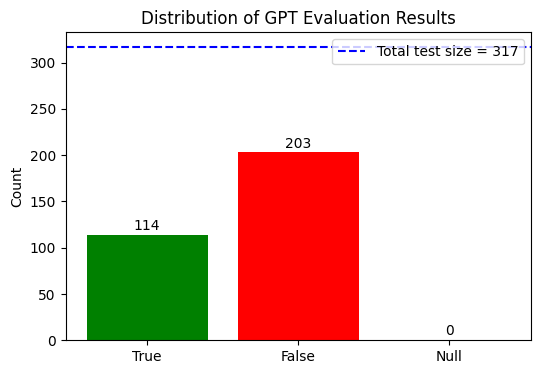

In [27]:
def plot_eval_distribution(df, total_size=317):
    """
    Visualize counts of True, False, and NaN in df['gpt_eval']
    relative to the total dataset size.
    """
    # Count values
    counts = df["gpt_eval"].value_counts(dropna=False)
    true_count = counts.get(True, 0)
    false_count = counts.get(False, 0)
    null_count = counts.get(pd.NA, 0) + counts.get(None, 0) + counts.get(float('nan'), 0)
    
    categories = ["True", "False", "Null"]
    values = [true_count, false_count, null_count]

    # Ensure they sum correctly against total_size
    print(f"True: {true_count}, False: {false_count}, Null: {null_count}, Total processed: {sum(values)} / {total_size}")

    # Plot
    plt.figure(figsize=(6,4))
    bars = plt.bar(categories, values, color=["green", "red", "gray"])
    plt.axhline(total_size, color="blue", linestyle="--", label=f"Total test size = {total_size}")
    plt.title("Distribution of GPT Evaluation Results")
    plt.ylabel("Count")
    plt.legend()
    
    # Add labels on bars
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 str(val), ha="center", va="bottom")

    plt.show()

# Example usage:
plot_eval_distribution(df, total_size=len(df))


In [ ]:
# Comparing the model's with respect to number of training iterations
df_0 = pd.read_parquet('/home/odedh/SML-For-Debug/benchmark/gpt_eval_checkpoints/benchmark_df_gpt_eval_pretrained.parquet')
df_500 =pd.read_parquet('/home/odedh/SML-For-Debug/benchmark/gpt_eval_checkpoints/benchmark_df_gpt_eval_fine_tuned_500it.parquet')
df_1000 = pd.read_parquet('/home/odedh/SML-For-Debug/benchmark/gpt_eval_checkpoints/benchmark_df_gpt_eval_fine_tuned_1000it.parquet')
df_1500 = pd.read_parquet('/home/odedh/SML-For-Debug/benchmark/gpt_eval_checkpoints/benchmark_df_gpt_eval_fine_tuned_1500it.parquet')
df_2000 = pd.read_parquet('/home/odedh/SML-For-Debug/benchmark/gpt_eval_checkpoints/benchmark_df_gpt_eval_fine_tuned_2000it.parquet')
# df_2500 = pd.read_parquet('/home/odedh/SML-For-Debug/benchmark/gpt_eval_checkpoints/benchmark_df_gpt_eval_fine_tuned_25000it.parquet')
# df_3000 = pd.read_parquet('/home/odedh/SML-For-Debug/benchmark/gpt_eval_checkpoints/benchmark_df_gpt_eval_fine_tuned_3000it.parquet')
df_7000 = pd.read_parquet('/home/odedh/SML-For-Debug/benchmark/gpt_eval_checkpoints/benchmark_df_gpt_eval_fine_tuned_7000it.parquet')

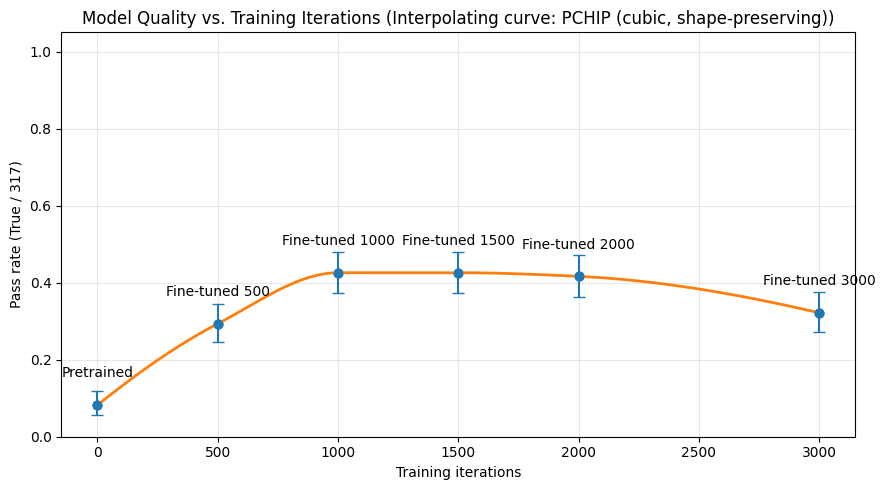

Used BS=6 (Training and Evaluation),
#Train samples = 2861, #Test samples = 317, Epoch = ~477steps


In [46]:
# ---- helper: Wilson 95% CI for binomial proportion ----
def wilson_interval(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + (z**2) / n
    center = (phat + (z**2) / (2 * n)) / denom
    half = z * np.sqrt((phat * (1 - phat) + (z**2) / (4 * n)) / n) / denom
    return (max(0.0, center - half), min(1.0, center + half))

# ---- summarize each checkpoint ----
TOTAL = len(df_0)  # fixed at 317 in your setup
checkpoints = [
    ("Pretrained", 0,      df_0),
    ("Fine-tuned 500", 500,  df_500),
    ("Fine-tuned 1000", 1000, df_1000),
    ("Fine-tuned 1500", 1500, df_1000),
    ("Fine-tuned 2000", 2000, df_2000),
    ("Fine-tuned 3000", 3000, df_7000),
]
missing_steps = []


rows = []
for label, iters, df in checkpoints:
    true_cnt  = int((df["gpt_eval"] == True).sum())
    false_cnt = int((df["gpt_eval"] == False).sum())
    null_cnt  = int(df["gpt_eval"].isna().sum())
    acc = true_cnt / TOTAL                    # treat null as incorrect for “pass rate”
    lo, hi = wilson_interval(true_cnt, TOTAL)
    rows.append(dict(label=label, iterations=iters, true=true_cnt,
                     false=false_cnt, null=null_cnt, accuracy=acc,
                     ci_low=lo, ci_high=hi))

summary = pd.DataFrame(rows).sort_values("iterations").reset_index(drop=True)

# x,y from your summary table (already sorted)
x = summary["iterations"].to_numpy(float)
y = summary["accuracy"].to_numpy(float)

# Prefer a smooth, shape-preserving cubic that goes through all points
try:
    from scipy.interpolate import PchipInterpolator  # pip install scipy
    interp = PchipInterpolator(x, y, extrapolate=True)   # C1-continuous, no overshoot
    interp_name = "PCHIP (cubic, shape-preserving)"
except Exception:
    # Fallback: exact but piecewise-linear
    def _lin_interp(xx):
        return np.interp(xx, x, y, left=np.nan, right=np.nan)
    class _LinearInterp:
        def __call__(self, xx): return _lin_interp(xx)
    interp = _LinearInterp()
    interp_name = "Linear interpolation (fallback)"

# Grid for smooth curve
x_grid = np.linspace(x.min(), x.max(), 400)
y_grid = np.clip(interp(x_grid), 0.0, 1.0)

# Points to predict (add whatever you want)
pred = {s: float(np.clip(interp([s])[0], 0.0, 1.0)) for s in missing_steps}

# ---- plot ----
plt.figure(figsize=(9, 5))

# observed with 95% CI bars (from your summary)
yerr_lower = summary["accuracy"] - summary["ci_low"]
yerr_upper = summary["ci_high"] - summary["accuracy"]
plt.errorbar(summary["iterations"], summary["accuracy"],
             yerr=[yerr_lower, yerr_upper], fmt="o", capsize=4, linewidth=1.5)

# interpolating curve that passes through all points
plt.plot(x_grid, y_grid, linewidth=2)

# show the observed points explicitly (they lie on the curve)
plt.scatter(x, y, s=40)

# extrapolated markers & labels
for s in missing_steps:
    plt.scatter([s], [pred[s]], marker="x", s=80, linewidths=2)
    plt.annotate(f"{s} it → {pred[s]*100:.1f}%",
                 xy=(s, pred[s]), xytext=(6, -12), textcoords="offset points")

# annotate observed points with labels
for _, r in summary.iterrows():
    plt.annotate(r["label"], xy=(r["iterations"], r["accuracy"]),
                 xytext=(0, 20), textcoords="offset points", ha="center")

plt.title(f"Model Quality vs. Training Iterations (Interpolating curve: {interp_name})")
plt.xlabel("Training iterations")
plt.ylabel(f"Pass rate (True / {TOTAL})")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print numeric predictions
for s in missing_steps:
    print(f"Predicted pass rate at {s} iterations: {pred[s]*100:.1f}%")
    
print(f"Used BS=6 (Training and Evaluation),\n#Train samples = 2861, #Test samples = 317, Epoch = ~477steps")
